In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Csv  files/Alzheimer data.csv")


In [ ]:

data.head(3)

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,09-01-2005,AD,09-12-2005,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/05,LMCI,11-08-2005,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,09-02-2005,CN,09-07-2005,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN


**Plotting the counts of imputed genotype across different diagnoses (DX.bl)**

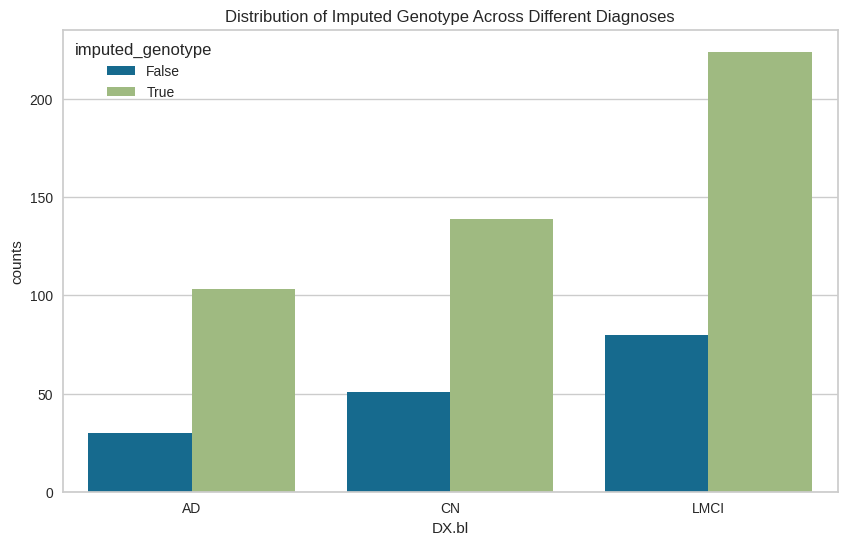

In [ ]:

counts = data.groupby(['DX.bl', 'imputed_genotype']).size().reset_index(name='counts')

plt.figure(figsize=(10,6))
ax = sns.barplot(x="DX.bl", y="counts", hue="imputed_genotype", data=counts)
ax.set_title('Distribution of Imputed Genotype Across Different Diagnoses')
plt.show()

# Analysis of target  Y distribution

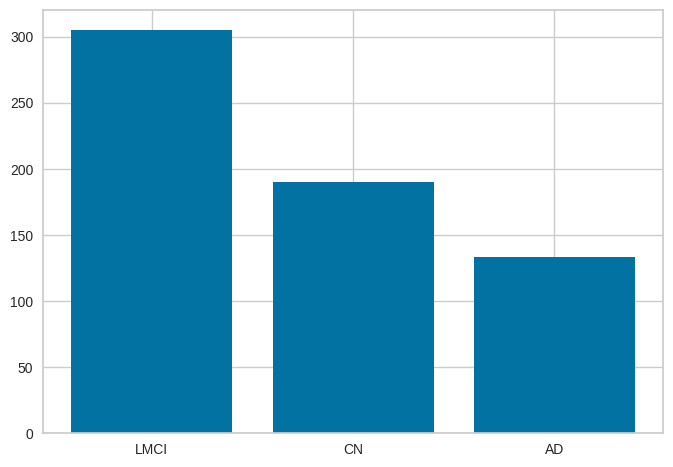

In [ ]:
plt.bar(Y.value_counts().index, Y.value_counts())
plt.show()

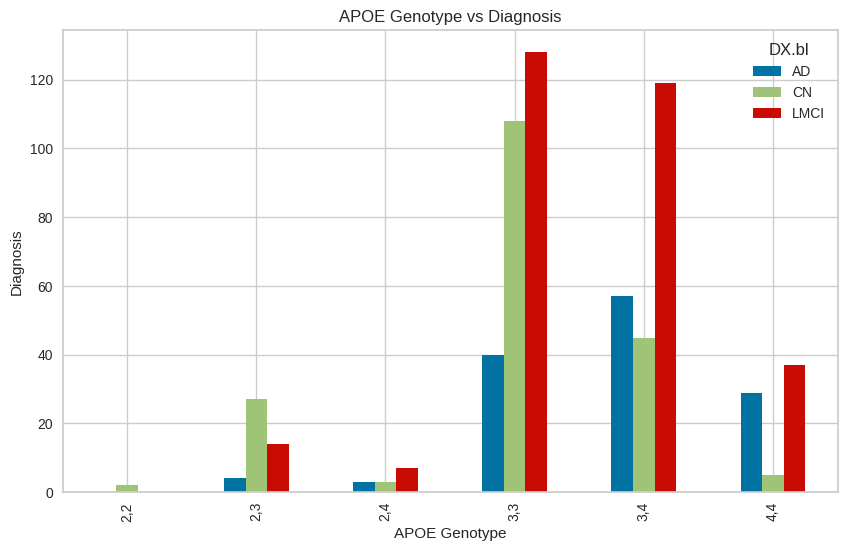

In [ ]:
ax = data.groupby(['APOE Genotype', 'DX.bl']).size().unstack().plot(kind='bar', figsize=(10,6))

ax.set_title('APOE Genotype vs Diagnosis')
ax.set_xlabel('APOE Genotype')
ax.set_ylabel('Diagnosis')

plt.show()

In [ ]:
X = data
Y = data['DX.bl']
del data

#Remove unnecessary columns (features), remove first 9 columns and 'Dx codes for submission'
remove_columns = list(X.columns)[0:9]
remove_columns.append('Dx Codes for Submission')
print('Removing columns:', remove_columns)

X = X.drop(remove_columns, axis=1)

features = list(X.columns)
X.head(5)

Removing columns: ['directory.id', 'Subject', 'RID', 'Image.Data.ID', 'Modality', 'Visit', 'Acq.Date', 'DX.bl', 'EXAMDATE', 'Dx Codes for Submission']


,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4"


In [ ]:
numerical_vars = ['AGE', 'MMSE', 'PTEDUCAT']
cat_vars = list(set(features) - set(numerical_vars))

print('Categorical variable distributions:\n')

for var in cat_vars:
    print('\nDistribution of', var)

    print(X[var].value_counts())

Categorical variable distributions:


Distribution of APOE4
APOE4
0    323
1    234
2     71
Name: count, dtype: int64

Distribution of PTETHCAT
PTETHCAT
Not Hisp/Latino    617
Hisp/Latino          8
Unknown              3
Name: count, dtype: int64

Distribution of APOE Genotype
APOE Genotype
3,3    276
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: count, dtype: int64

Distribution of PTGENDER
PTGENDER
Male      364
Female    264
Name: count, dtype: int64

Distribution of PTRACCAT
PTRACCAT
White    584
Black     31
Asian     13
Name: count, dtype: int64

Distribution of imputed_genotype
imputed_genotype
True     466
False    161
Name: count, dtype: int64


Categorical Var Distribution Notes




```
Ethnicity and Race are separate vars
Distribution of Hispanic, Black, White, Asian not quite same as overall American ethnic/racial distribution
APOE Genotype with 3 in the first spot seems to be overwhelming majority 3,3 and 3,4
More males in study than females
Numerical Variable Distributions
All 3 distributions seem a bit right-skewed
Age: mean = 75, min=55, max=89 - seems to be no obvious bad data
MMSE: mean = 26.9, min=20, max=30 - seems to be no obvious bad data, NOTE: MMSE


#PTEDUCAT: mean = 15.6, min=6, max=20 - seems to be no obvious bad data. 13-14 yrs is probably high school/GED and 17-18 years is likely Bachelor's degree
```




In [ ]:
#for each categorical var, convert to 1-hot encoding
for var in cat_vars:
    print('Converting', var, 'to 1-hot encoding')

    #get 1-hot and replace original column with the >= 2 categories as columns
    one_hot_df = pd.get_dummies(X[var])
    X = pd.concat([X, one_hot_df], axis=1)
    X = X.drop(var, axis=1)

X.head(4)

Converting APOE4 to 1-hot encoding
Converting PTETHCAT to 1-hot encoding
Converting APOE Genotype to 1-hot encoding
Converting PTGENDER to 1-hot encoding
Converting PTRACCAT to 1-hot encoding
Converting imputed_genotype to 1-hot encoding


,AGE,PTEDUCAT,MMSE,0,1,2,Hisp/Latino,Not Hisp/Latino,Unknown,"2,2",...,"3,3","3,4","4,4",Female,Male,Asian,Black,White,False,True
0,81.3,18,20,False,True,False,False,True,False,False,...,False,True,False,False,True,False,False,True,False,True
1,67.5,10,27,True,False,False,True,False,False,False,...,True,False,False,False,True,False,False,True,True,False
2,73.7,16,29,True,False,False,False,True,False,False,...,True,False,False,False,True,False,False,True,False,True
3,80.4,13,25,True,False,False,False,True,False,False,...,True,False,False,True,False,False,False,True,False,True


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

print('X_train:', X_train.shape, '\ty_train:', y_train.shape)
print('X_test:', X_test.shape, '\ty_test:', y_test.shape)
num_test = X_test.shape[0]

X_train: (502, 22) 	y_train: (502,)
X_test: (126, 22) 	y_test: (126,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score

**LOGISTIC REGRESSION**

In [ ]:
# Convert all feature names to strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

log_clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000000, multi_class='multinomial')
print('Validation Accuracy = ', format(cross_val_score(log_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  68.13%


**RANDOM FOREST**

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200)
print('Validation Accuracy = ', format(cross_val_score(rf_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  61.97%


**KNN CLASSIFIER**

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
print('Validation Accuracy = ', format(cross_val_score(knn_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  67.53%



1.   Remember:
PTGENDER: (Male, Female)
imputed_genotype (True, False)
2.  PTETHCAT: (Hisp/Latino, Not Hisp/Latino, Unknown)
3. PTRACCAT: (White, Black, Asian)
4. APOE4: (0, 1, 2)
5.APOE4 Genotype: (22, 23, 24, 33, 34, 44)

